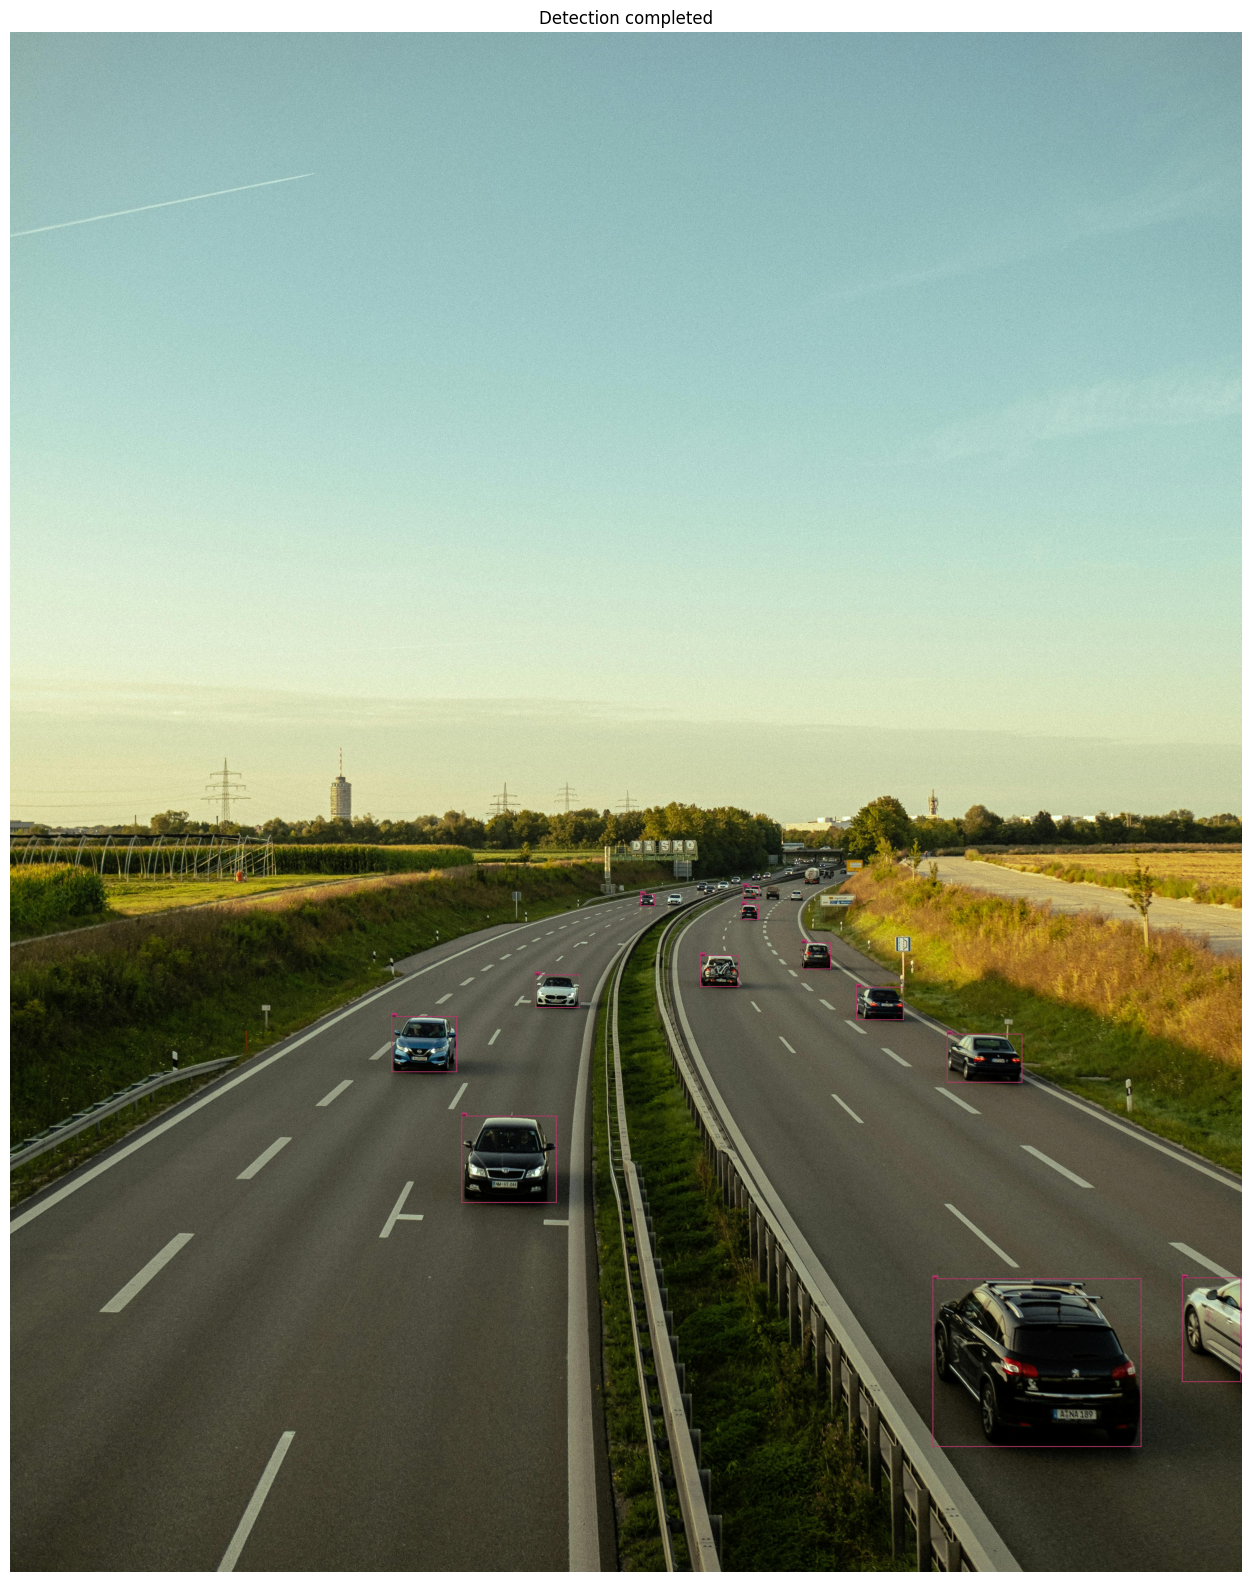

In [1]:
import requests
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import matplotlib.pyplot as plt
import random


# Set up parameters
endpoint = "http://localhost:8000/detection"

image_list = ["https://images.unsplash.com/photo-1589828155685-83225f7d91f3?q=80&w=1310&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
              "https://ix-cdn.b2e5.com/images/27094/27094_3063d356a3a54cc3859537fd23c5ba9d_1539205710.jpeg",
              "https://motionarray.imgix.net/motion-array-1228771-gUg9Vp05ih-high_0010.jpg?w=660&q=60&fit=max&auto=format",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSpbXGdlGtbifsqb2f4_BwIpbofb1PAKYA_qw&s",
              "https://images.unsplash.com/photo-1657983010209-b9e3a7b1b25c?q=80&w=1935&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
              "https://images.pexels.com/photos/9591607/pexels-photo-9591607.jpeg"
              ]
image_url = image_list[5]  # Select

# Step 1: Call the FastAPI detection endpoint
response = requests.get(endpoint, params={"image_url": image_url})
response.raise_for_status()
result = response.json()

# Step 2: Download the image
image_response = requests.get(image_url)
image_response.raise_for_status()
image = Image.open(BytesIO(image_response.content)).convert("RGB")
image_width, image_height = image.size

# Step 3: Prepare drawing
draw = ImageDraw.Draw(image)
try:
    font = ImageFont.truetype("arial.ttf", 20)
except IOError:
    font = ImageFont.load_default()

# Generate a consistent color for each class
def get_class_colors(classes):
    random.seed(42)  # Make colors consistent across runs
    return {cls: tuple(random.choices(range(50, 255), k=3)) for cls in classes}

# Extract detections
detections = result.get("detections", {}).get("objects", [])
all_classes = set(obj["class_"] for obj in detections)
class_colors = get_class_colors(all_classes)

# Better font size
font_size = max(int(image_height * 0.2), 50)  # 20% of image height or at least 50px
try:
    font = ImageFont.truetype("arial.ttf", font_size)
except IOError:
    font = ImageFont.load_default()

# Draw each detection
for obj in detections:
    label = obj["class_"]
    bbox = obj["bbox"]
    color = class_colors[label]

    # Convert normalized bbox to pixel coordinates
    x_center = bbox["x_center"] * image_width
    y_center = bbox["y_center"] * image_height
    width = bbox["width"] * image_width
    height = bbox["height"] * image_height

    x0 = x_center - width / 2
    y0 = y_center - height / 2
    x1 = x_center + width / 2
    y1 = y_center + height / 2

    # Draw bounding box
    draw.rectangle([x0, y0, x1, y1], outline=color, width=3)

    # Label text
    text = label
    bbox_text = font.getbbox(text)
    text_width = bbox_text[2] - bbox_text[0]
    text_height = bbox_text[3] - bbox_text[1]

    text_x = x0 + 2
    text_y = max(y0 - text_height - 2, 0)

    # Draw background rectangle for label
    draw.rectangle(
        [text_x - 2, text_y - 2, text_x + text_width + 2, text_y + text_height + 2],
        fill=color
    )

    # Draw text label (with high contrast)
    draw.text((text_x, text_y), text, fill="black", font=font)

# Step 5: Display the image
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis("off")
plt.title(result["message"])
plt.show()
